In [71]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import matplotlib.colors as colors
import astropy.coordinates as coord
from matplotlib.colors import LogNorm

#### **Select the 20 brightest objects in the Observation map**

In [72]:
%store -r table_PS_obs

In [73]:
table_PS_obs_sorted = table_PS_obs.sort_values(by='S(Jy)', ascending=False)

top_20 = table_PS_obs_sorted.head(20)

table_PS_obs_brightest = top_20.copy()

In [74]:
%store -r lon
%store -r lat
%store -r xsize
%store -r reso

In [75]:
lon_PS_obs = table_PS_obs_brightest['lon(°)']
lat_PS_obs = table_PS_obs_brightest['lat(°)']

In [76]:
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)
lon_PS_obs_rad = np.radians(lon_PS_obs.values)
lat_PS_obs_rad = np.radians(lat_PS_obs.values)

In [77]:
#reso is in arcmin
def convert_lonlat_to_patch_position(lon_PS, lat_PS, lon_PS_rad, lat_PS_rad, lon = lon, lat = lat, xsize = xsize, reso = reso):
    patch_positions = []

    for lon_PS_rad, lat_PS_rad, lon_PS, lat_PS in zip(lon_PS_rad, lat_PS_rad, lon_PS, lat_PS):
        
        patch_index = np.argmin(coord.angular_separation(lon_PS_rad, lat_PS_rad, lon_rad, lat_rad))

        patch_lon, patch_lat = lon[patch_index], lat[patch_index]

        proj = hp.projector.GnomonicProj(ysize=xsize, xsize=xsize, rot=(patch_lon, patch_lat, 0), reso=reso)
        x, y = proj.ang2xy(lon_PS, lat_PS, lonlat=True)
        i,j = proj.xy2ij(x = x, y = y)
        

        patch_positions.append((patch_index, i, j))

    return patch_positions

In [78]:
brightest20_obs = convert_lonlat_to_patch_position(lon_PS_obs, lat_PS_obs, lon_PS_obs_rad, lat_PS_obs_rad)

In [80]:
%store brightest20_obs

Stored 'brightest20_obs' (list)


#### **Point source only B map**

In [83]:
#From TFM/Observation data/Simulation/Simulation_27GHz_obs.ipynb

In [79]:
%store -r B_obs

In [ ]:
ps_map_B_obs_patches = [hp.gnomview(B_obs, rot=[lon[i], lat[i]], xsize = xsize, reso = reso, return_projected_map = True, no_plot = True) for i in range(len(lon))]

#### **Patch comparison**

In [40]:
# Store the prediction
%store -r prediction_B_64pix_9epoch_10batch

In [5]:
# Store the observation
%store -r map_cut_data_B_obs

In [6]:
patch_numbers = [item[0] for item in brightest20_obs]
peak_patch_x = [item[2] for item in brightest20_obs]
peak_patch_y = [item[1] for item in brightest20_obs]

In [41]:
%store -r prediction_B_64pix_9epoch_10batch_foregrounds

In [43]:
%store -r map_cut_data_B_obs_foregrounds

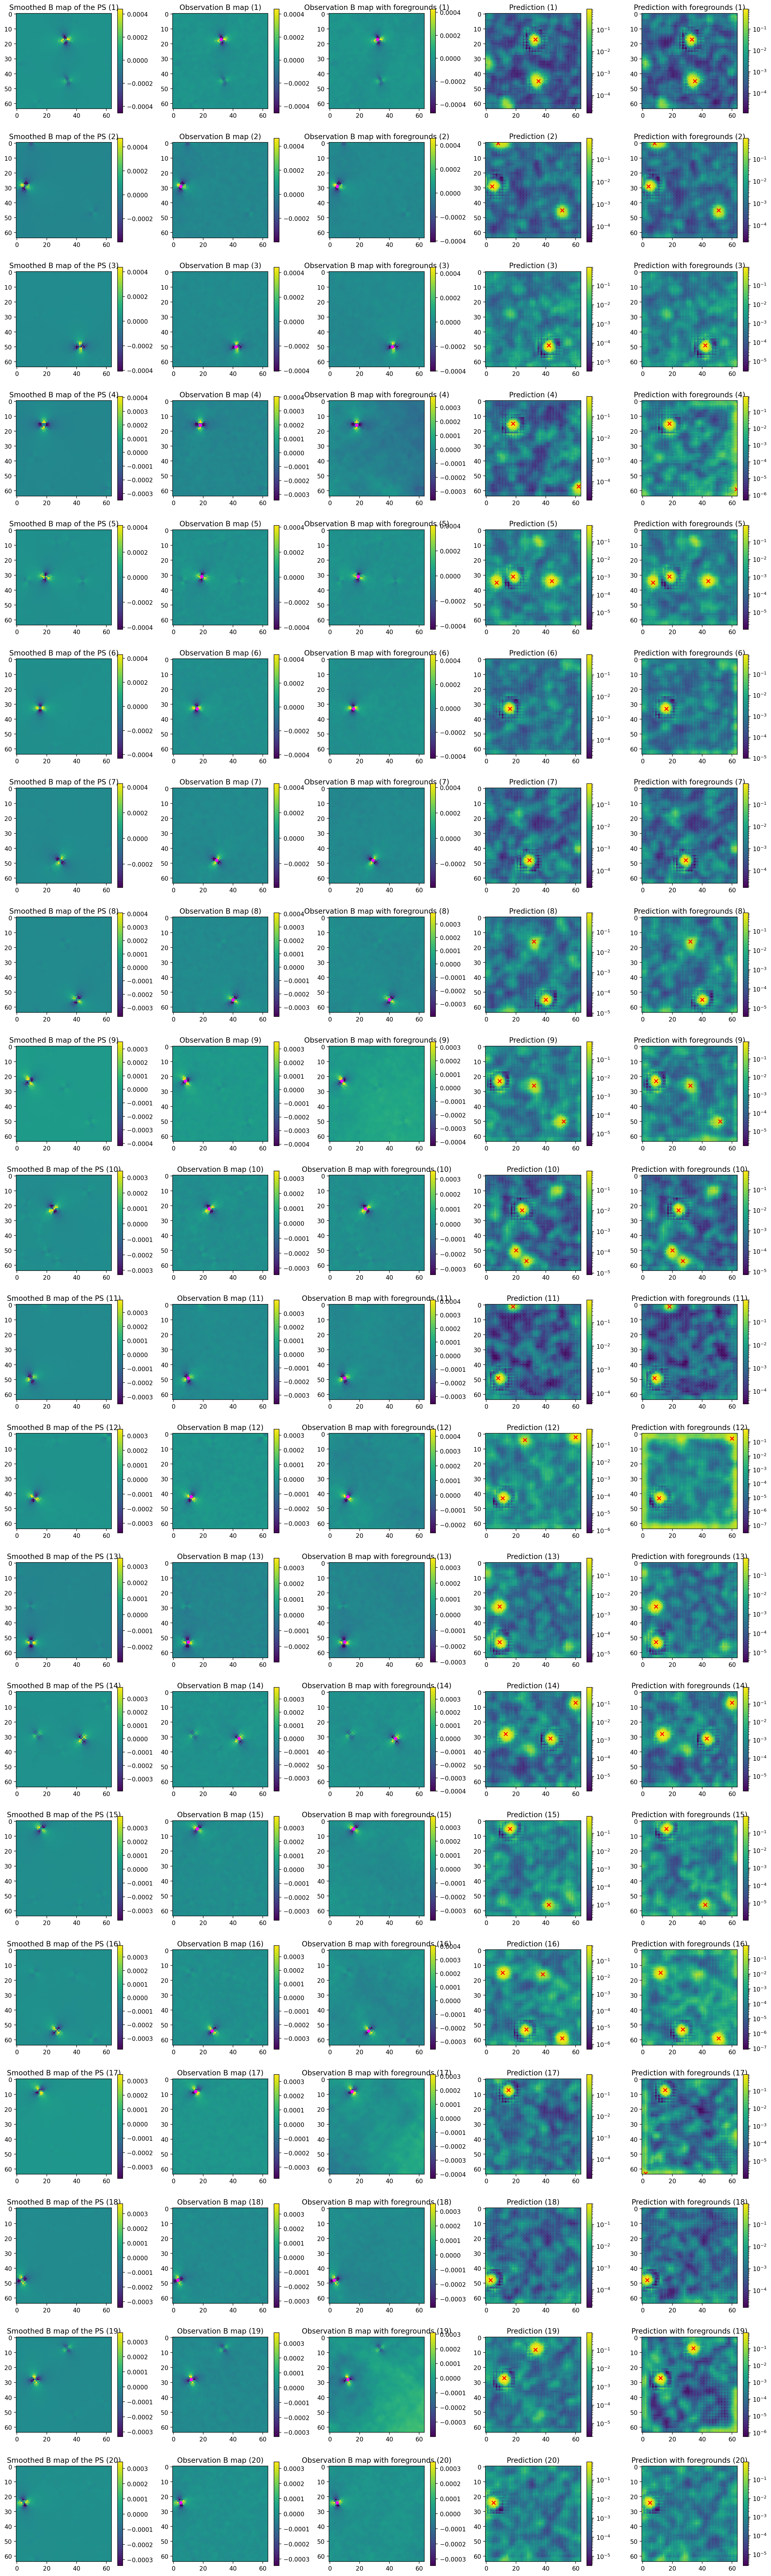

In [9]:
fig, axes = plt.subplots(20, 5, figsize=(18, 60), dpi=200)

for i, (patch_number, peak_x, peak_y) in enumerate(zip(patch_numbers[:20], peak_patch_x[:20], peak_patch_y[:20])):
    
    def test(observation, prediction, foregrounds, n=patch_number, peak_distance_tol=5): 
        observation = np.squeeze(observation[n])
        prediction = np.squeeze(prediction[n])
        foregrounds = np.squeeze(foregrounds[n])
        prediction_peaks = peak_local_max(prediction[:, :], threshold_abs = 0.3, min_distance=peak_distance_tol, exclude_border=False)
        foregrounds_peaks = peak_local_max(foregrounds[:, :], threshold_abs = 0.3, min_distance=peak_distance_tol, exclude_border=False)
        return prediction_peaks, observation, prediction, foregrounds, foregrounds_peaks  
    
        
    # S_new_obs plot
    ax1 = axes[i, 0]    
    sc1 = ax1.imshow(ps_map_B_obs_patches[patch_number])
    cbar1 = fig.colorbar(sc1, ax=ax1)
    ax1.set_title(f"Smoothed B map of the PS ({i+1})")

        
    # Observation
    ax2 = axes[i, 1]  
    image_data2 = test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[1]
    sc2 = ax2.imshow(image_data2)
    ax2.scatter(x=peak_x, y=peak_y, color='magenta', s=20)
    cbar2 = fig.colorbar(sc2, ax=ax2)
    ax2.set_title(f"Observation B map ({i+1})")
    
    # Observation with foregrounds
    ax2 = axes[i, 2]  
    image_data2 = map_cut_data_B_obs_foregrounds[patch_number][:,:,0]
    sc2 = ax2.imshow(image_data2)
    ax2.scatter(x=peak_x, y=peak_y, color='magenta', s=20)
    cbar2 = fig.colorbar(sc2, ax=ax2)
    ax2.set_title(f"Observation B map with foregrounds ({i+1})")

    
    # Prediction
    ax3 = axes[i, 3]  
    image_data3 = test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[2]
    sc3 = ax3.imshow(image_data3, norm=colors.LogNorm())
    ax3.scatter(x=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[0][:, 1],
                y=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[0][:, 0], 
                c='red', marker='x')
    cbar3 = fig.colorbar(sc3, ax=ax3)
    ax3.set_title(f"Prediction ({i+1})")
    
    # Prediction with foregrounds
    ax4 = axes[i, 4]  
    image_data4 = test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[3]
    sc4 = ax4.imshow(image_data4, norm=colors.LogNorm())
    ax4.scatter(x=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[4][:, 1],
                y=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch, prediction_B_64pix_9epoch_10batch_foregrounds)[4][:, 0], 
                c='red', marker='x')
    cbar4 = fig.colorbar(sc4, ax=ax4)
    ax4.set_title(f"Prediction with foregrounds ({i+1})")



plt.tight_layout()
plt.savefig('Foreground_patches.pdf')
plt.show()